### Imports

In [48]:
import numpy as np
import math
import sympy
from sympy import symbols, lambdify, I, latex
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

%config InlineBackend.figure_format = 'retina'

### Setup

Calculate the series approximation of the hamiltonian

In [49]:
# Define all the variables
x = symbols("x")
x_bar = symbols(r"\bar{x}")
omega_0 = symbols(r"\omega_0", real = True)

# Define function: h_2n
def h_2n(n_val, x_val, x_bar_val, omega_0_val):
	return ((-1)**(n_val+1) * omega_0_val**2 / math.factorial(2*n_val)) * (1 / (2*omega_0_val))**n_val * (x_val + x_bar_val)**(2*n_val)

# Define the Hamiltonian function: h 
h = omega_0 * x * x_bar

for i in range(2,4):
	h += h_2n(i, x, x_bar, omega_0)

h_f = lambdify([x, x_bar, omega_0], h)

h

\bar{x}*\omega_0*x - (\bar{x} + x)**4/96 + (\bar{x} + x)**6/(5760*\omega_0)

Define utilities for lie series and the true transformation from hadden paper

In [50]:
### Lie transformation utilities
def compose(f, n):
    # from https://stackoverflow.com/a/58850806/6454085
    def fn(x):
        for _ in range(n):
            x = f(x)
        return x
    return fn

def poisson_bracket(f, g, q, p):
    return I * f.diff(q) * g.diff(p) - I * f.diff(p) * g.diff(q)
pb = lambda f,g: poisson_bracket(f, g, x_bar, x)

def lie_transformation(f, chi, order):
    fp = 0
    for i in range(order):
        fp += 1/math.factorial(i) * compose(lambda f: pb(f, chi), i)(f)
    return fp

### True transformation from hadden paper
chi_4 = 1/(I*omega_0) * (x**3 * x_bar/48 - x*x_bar**3/48 - x_bar**4/384 + x**4/384)
chi_6 = 1/(I*omega_0**2) *  (-x**6/15360 + x**5*x_bar/15360 + 7*x**4*x_bar**2/3072 - 7*x**2*x_bar**4/3072 - x*x_bar**5/15369 + x_bar**6/15360)

chi = chi_4+chi_6

# xp = x + pb(x, chi) + (1/2) * pb(pb(x, chi), chi)
# xp_bar = x_bar + pb(x_bar, chi) + (1/2) * pb(pb(x_bar, chi), chi)

lie_order = 3
xp = lie_transformation(x, -chi, lie_order)
xp_bar = lie_transformation(x_bar, -chi, lie_order)

xp_f = lambdify([x, x_bar, omega_0], xp)
xp_bar_f = lambdify([x, x_bar, omega_0], xp_bar)

### Integrate Original DE

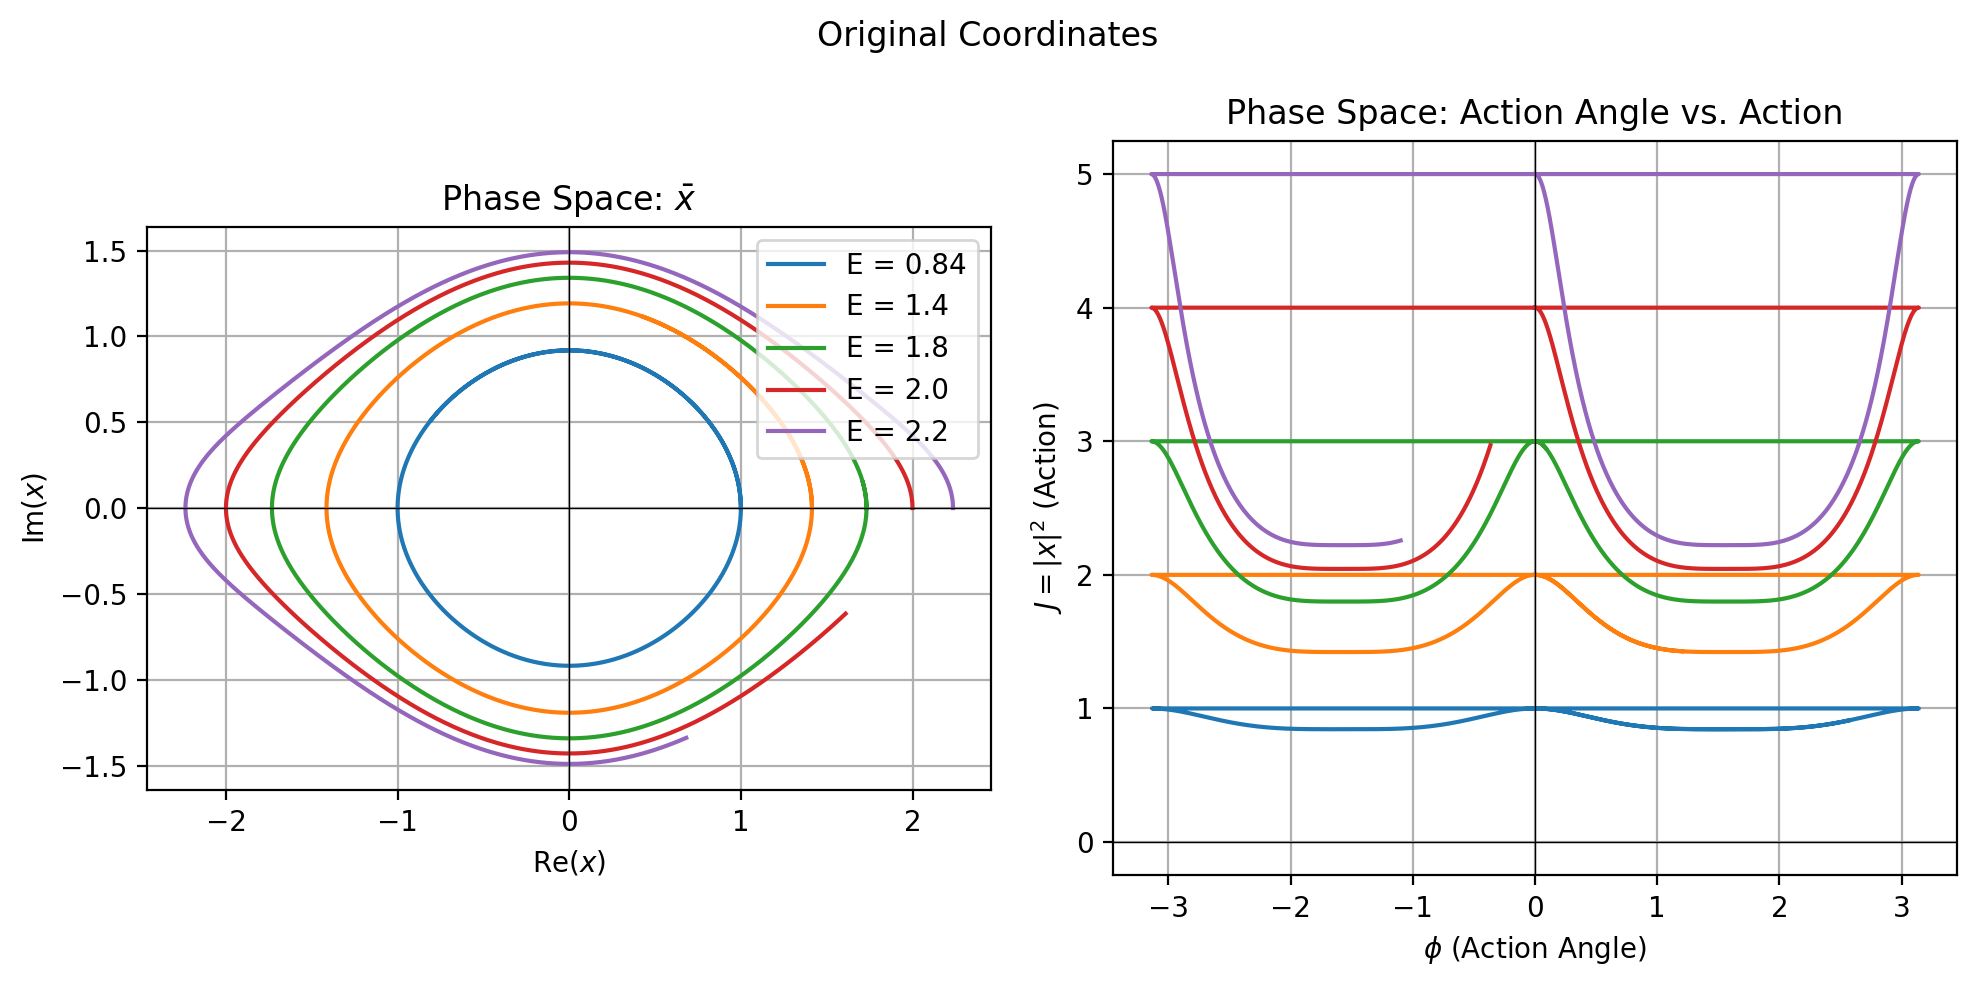

In [51]:
# Differentiate with respect to x_bar
dhdx_bar = lambdify([x, x_bar, omega_0], h.diff(x_bar) * I)

# Natural frequency of the system
omega_0_val = 1.0

# Define the Hamiltonian system in terms of x and x bar
def hamiltonian_system(time, z):
    x = z[0] + 1j * z[1]  # Convert to complex form
    dxdt = dhdx_bar(x, x.real - 1j * x.imag, omega_0_val)
    return [dxdt.real, dxdt.imag]

# Define different energy levels for hamiltonian
energy_levels = [1.0, 2.0, 3.0, 4.0, 5.0]

t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(energy_levels)):
    H = energy_levels[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    # x0 = fsolve(lambda x: h_f(x + 0j, 0 + 0j, 1).real - H, [2])
    z0 = [x0.real, x0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    # x_bar_sol = sol.y[2] + 1j * sol.y[3]
    x_bar_sol = x_sol.real - 1j * x_sol.imag

    # Compute action variable J and action angle phi
    J_sol = np.abs(x_sol) ** 2
    phi_sol = np.angle(x_sol)

    # Plot phase space for x
    axes[0].plot(x_sol.real, x_sol.imag, label=f"E = {h_f(x_sol[0], x_bar_sol[0], omega_0_val).real:.2}")

    # Plot action angle space
    axes[1].plot(phi_sol, J_sol)
    
axes[0].legend(loc="upper right")
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $\bar{x}$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()
axes[0].set_aspect('equal')

axes[1].set_xlabel(r'$\phi$ (Action Angle)')
axes[1].set_ylabel(r'$J = |x|^2$ (Action)')
axes[1].set_title('Phase Space: Action Angle vs. Action')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()

plt.suptitle("Original Coordinates")

plt.tight_layout()
plt.show()

Plot the hamilonian over time to verify that its conserved and everything is working correctly

/home/kavidey/micromamba/envs/poel/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kavidey/micromamba/envs/poel/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


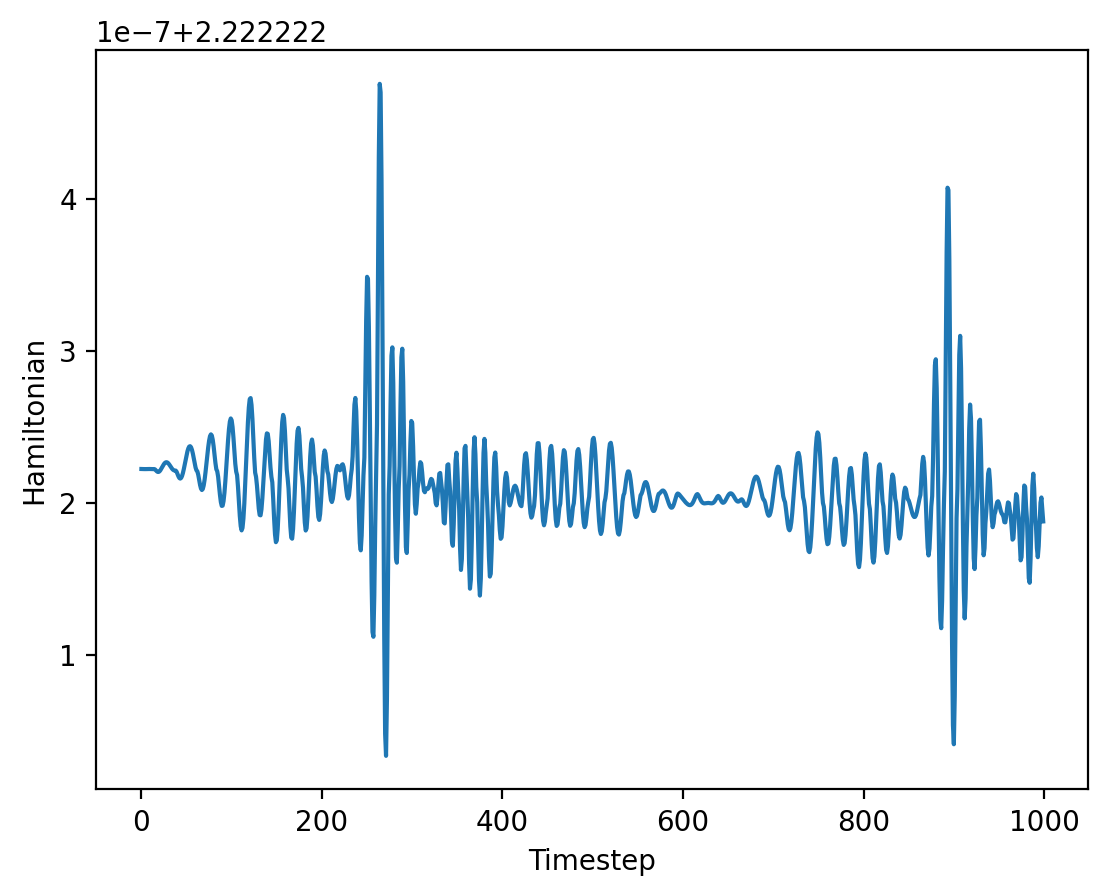

In [52]:
plt.plot(h_f(x_sol, x_bar_sol, omega_0_val))
plt.xlabel("Timestep")
plt.ylabel("Hamiltonian")
plt.show()


### Hadden Transformation

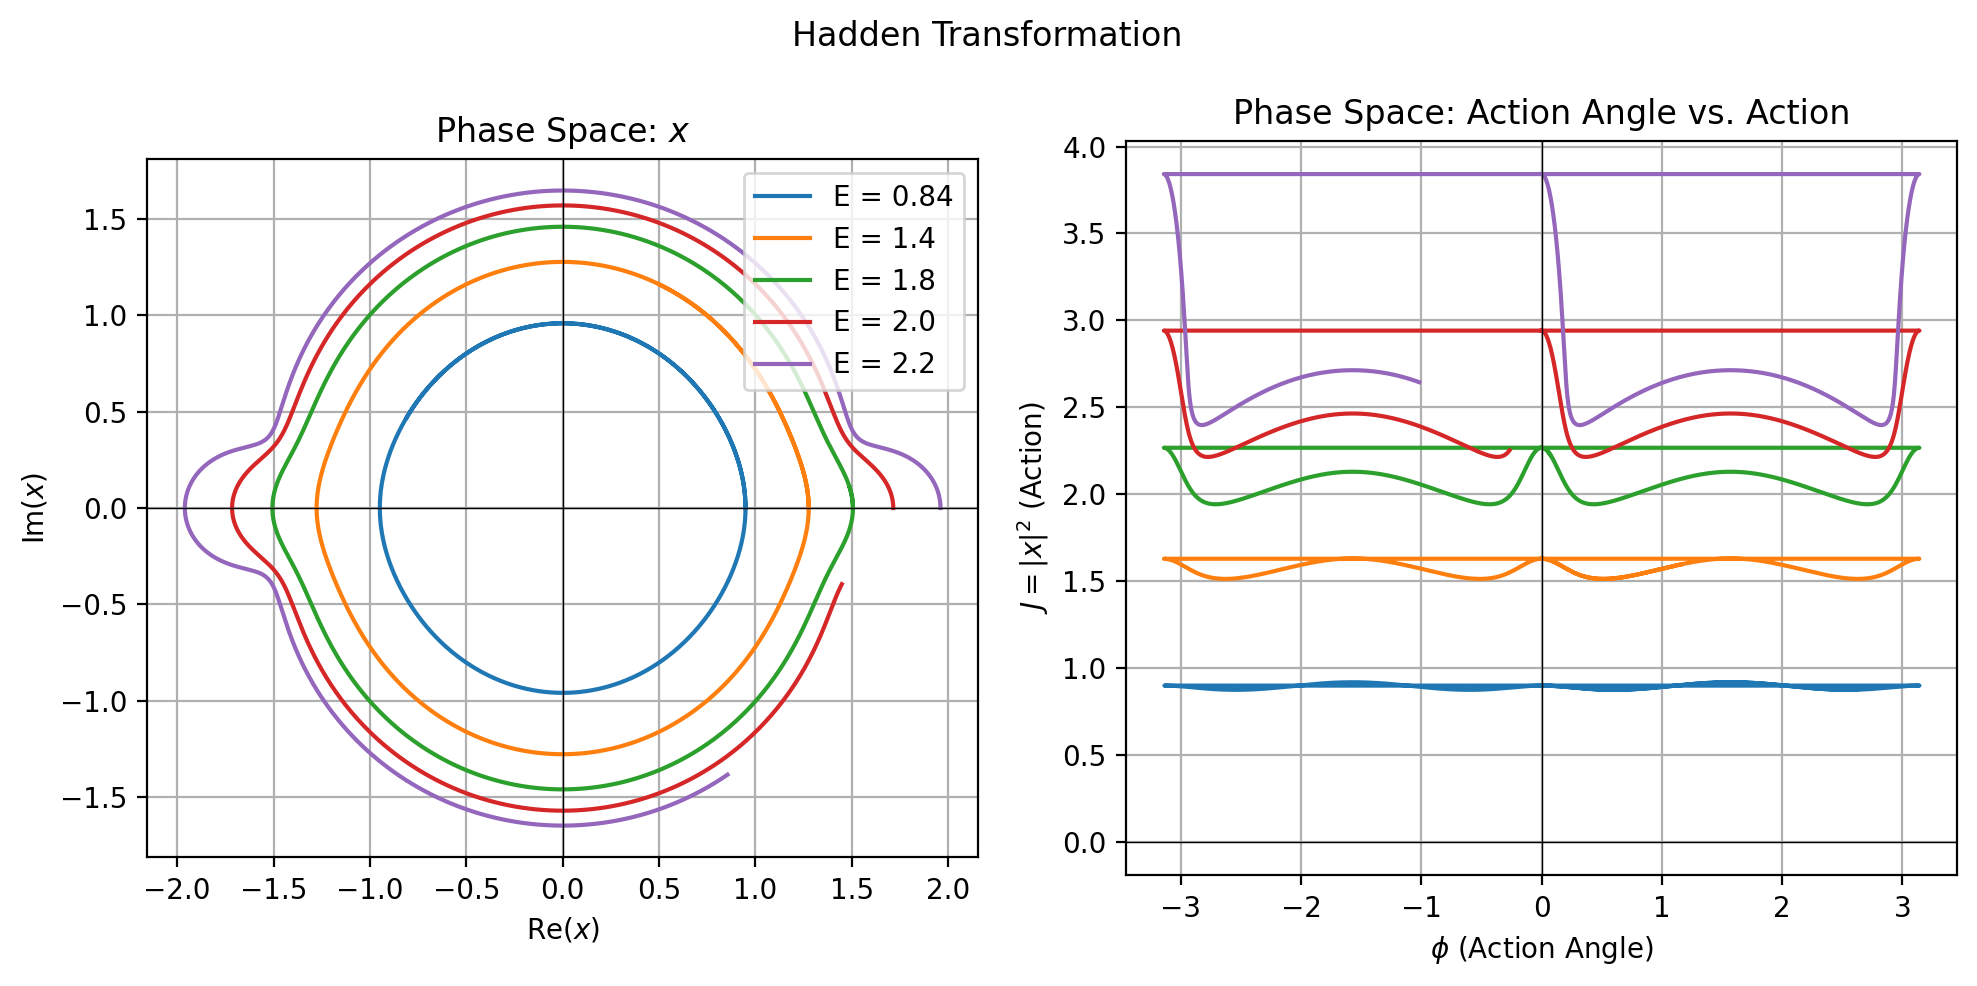

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(energy_levels)):
    H = energy_levels[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    z0 = [x0.real, x0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = x_sol.real + 1j * x_sol.imag

    xp_sol = xp_f(x_sol, x_bar_sol, omega_0_val)
    xp_bar_sol = xp_bar_f(x_sol, x_bar_sol, omega_0_val)

    # Compute action variable J and action angle phi
    J_sol = np.abs(xp_sol) ** 2
    phi_sol = np.angle(xp_sol)

    # Plot phase space for x
    axes[0].plot(xp_sol.real, xp_sol.imag, label=f"E = {h_f(x_sol[0], x_bar_sol[0], omega_0_val).real:.2}")

    # Plot action angle space
    axes[1].plot(phi_sol, J_sol)
    
axes[0].legend(loc="upper right")
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $x$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()
axes[0].set_aspect('equal')

axes[1].set_xlabel(r'$\phi$ (Action Angle)')
axes[1].set_ylabel(r'$J = |x|^2$ (Action)')
axes[1].set_title('Phase Space: Action Angle vs. Action')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()

plt.suptitle("Hadden Transformation")

plt.tight_layout()
plt.show()

### Optimize the coefficients of $\chi$ to create the "best" action angle variables

In [11]:
import scipy.optimize

In [54]:
def generate_lie_transforms():
    # Generate a parameterized version of the transformation
    coeffs = [sympy.Symbol(f"c_{i}") for i in range(11)]
    chi_4 = 1/(I*omega_0) * (x**3/coeffs[0] * x_bar/coeffs[1] + x*x_bar**3/coeffs[2] + x_bar**4/coeffs[3] + x**4/coeffs[3])
    chi_6 = 1/(I*omega_0**2) *  (x**6/coeffs[4] + x**5*x_bar/coeffs[6] + 7*x**4*x_bar**2/coeffs[7] + 7*x**2*x_bar**4/coeffs[8] + x*x_bar**5/coeffs[9] + x_bar**6/coeffs[10])

    chi = chi_4+chi_6

    # xp = x + pb(x, chi) + (1/2) * pb(pb(x, chi), chi)
    # xp_bar = x_bar + pb(x_bar, chi) + (1/2) * pb(pb(x_bar, chi), chi)

    lie_order = 3
    xp = lie_transformation(x, -chi, lie_order)
    xp_bar = lie_transformation(x_bar, -chi, lie_order)

    display(xp)

    xp_f = lambdify([x, x_bar, omega_0]+coeffs, xp)
    xp_bar_f = lambdify([x, x_bar, omega_0]+coeffs, xp_bar)

    return xp_f, xp_bar_f

### Alternate way of learning the transformation that skips chi
# def generate_parameterized_transforms():
#     coeffs = [sympy.Symbol(f"c_{i}") for i in range(4)]

#     xp = x + (coeffs[0])*(x*x_bar)**2 / math.factorial(2) + (coeffs[1])*(x*x_bar)**4 / math.factorial(4) + (coeffs[2])*(x*x_bar)**6 / math.factorial(6) + (coeffs[3])*(x*x_bar)**8 / math.factorial(8)
#     display(xp)

#     xp_f = lambdify([x, x_bar, omega_0]+coeffs, xp)
#     xp_bar_f = lambdify([x, x_bar, omega_0]+coeffs, xp_bar)

#     return xp_f, xp_bar_f

In [55]:
### Initial guess is starting coefficients from the hadden paper
true_coeffs = [1, 48, -48, -384, 384, -15360, 15360, 3072, -3072, -15369, 15360]
xp_f_param, _ = generate_lie_transforms()

# true_coeffs = np.array([1, 1, 1, 1]) * 0.1
# xp_f_param, _ = generate_parameterized_transforms()

### Initial conditions used for integration
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)
optim_h = [1,2,3,4,5]


### Pre-solve all of the ics since we're learning a transformation that is applied after integration
sols = []
for h in optim_h:
    # Solve the ODEs
    x0 = np.sqrt(h/omega_0_val) * np.exp(0)
    z0 = [x0.real, x0.imag]

    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = x_sol.real + 1j * x_sol.imag

    sols.append([x_sol, x_bar_sol])

def objective(coeffs, sols, debug=False, j_weight=0.1):
    err = 0
    for x_sol, x_bar_sol in sols:
        xp_sol = xp_f_param(x_sol, x_bar_sol, omega_0_val, *coeffs)

        # Compute action variable J and action angle phi
        J_sol = np.abs(xp_sol) ** 2
        phi_sol = np.angle(xp_sol)

        phi_sol_dot = np.gradient(phi_sol[(phi_sol > 0) & (phi_sol < np.pi)]) # get rid of angles outside of (0, pi) so we don't have to deal with discontinuities
        J_sol_cropped = J_sol[(phi_sol > 0) & (phi_sol < np.pi)]

        # calculate L1 distance between j and its mean and phi_dot and its mean
        j_err = np.sum(np.abs(J_sol_cropped - np.mean(J_sol_cropped)))
        phi_err = np.sum(np.abs(phi_sol_dot - np.mean(phi_sol_dot)))
        local_err = j_err * j_weight + phi_err
        if debug:
            print(j_err, phi_err, local_err)
        err += local_err
    return err

### Variety of optimization techinques, minimize works well and is fast
optimal_coeffs = scipy.optimize.minimize(lambda c: objective(c, sols), true_coeffs,
                        # method='BFGS',
                        method='nelder-mead',
                        options={
                            'xatol': 1e-8, # only available with nelder-mead
                            'disp': False
                            })

# optimal_coeffs = scipy.optimize.basinhopping(lambda c: objective(c, sols), true_coeffs, niter=200)

# optimal_coeffs = scipy.optimize.dual_annealing(lambda c: objective(c, sols), bounds=[(-1, 1)] * len(true_coeffs))

# optimal_coeffs = scipy.optimize.brute(lambda c: objective(c, sols), ranges=[(-1e10, 1e10)] * len(true_coeffs))

# np.int64(optimal_coeffs.x)
optimal_coeffs.x

1.0*x - 0.5*(I*(3*\bar{x}**2/c_2 + 3*x**2/(c_0*c_1))/\omega_0 + I*(5*\bar{x}**4/c_9 + 56*\bar{x}**3*x/c_8 + 56*\bar{x}*x**3/c_7 + 5*x**4/c_6)/\omega_0**2)*(I*(4*\bar{x}**3/c_3 + 3*\bar{x}**2*x/c_2 + x**3/(c_0*c_1))/\omega_0 + I*(6*\bar{x}**5/c_10 + 5*\bar{x}**4*x/c_9 + 28*\bar{x}**3*x**2/c_8 + 14*\bar{x}*x**4/c_7 + x**5/c_6)/\omega_0**2) + 0.5*(I*(12*\bar{x}**2/c_3 + 6*\bar{x}*x/c_2)/\omega_0 + I*(30*\bar{x}**4/c_10 + 20*\bar{x}**3*x/c_9 + 84*\bar{x}**2*x**2/c_8 + 14*x**4/c_7)/\omega_0**2)*(I*(\bar{x}**3/c_2 + 3*\bar{x}*x**2/(c_0*c_1) + 4*x**3/c_3)/\omega_0 + I*(\bar{x}**5/c_9 + 14*\bar{x}**4*x/c_8 + 28*\bar{x}**2*x**3/c_7 + 5*\bar{x}*x**4/c_6 + 6*x**5/c_4)/\omega_0**2) - 1.0*I*(I*(4*\bar{x}**3/c_3 + 3*\bar{x}**2*x/c_2 + x**3/(c_0*c_1))/\omega_0 + I*(6*\bar{x}**5/c_10 + 5*\bar{x}**4*x/c_9 + 28*\bar{x}**3*x**2/c_8 + 14*\bar{x}*x**4/c_7 + x**5/c_6)/\omega_0**2)

array([ 4.76732008e-02,  1.51350404e+03, -1.76800647e+03, -6.86566509e+01,
        8.87912249e+02,  1.61498384e+06,  3.59906391e+05,  7.91954035e+04,
       -3.62164834e+03, -1.56433086e+03,  7.73743070e+02])

plot again, now with the optimized transformation

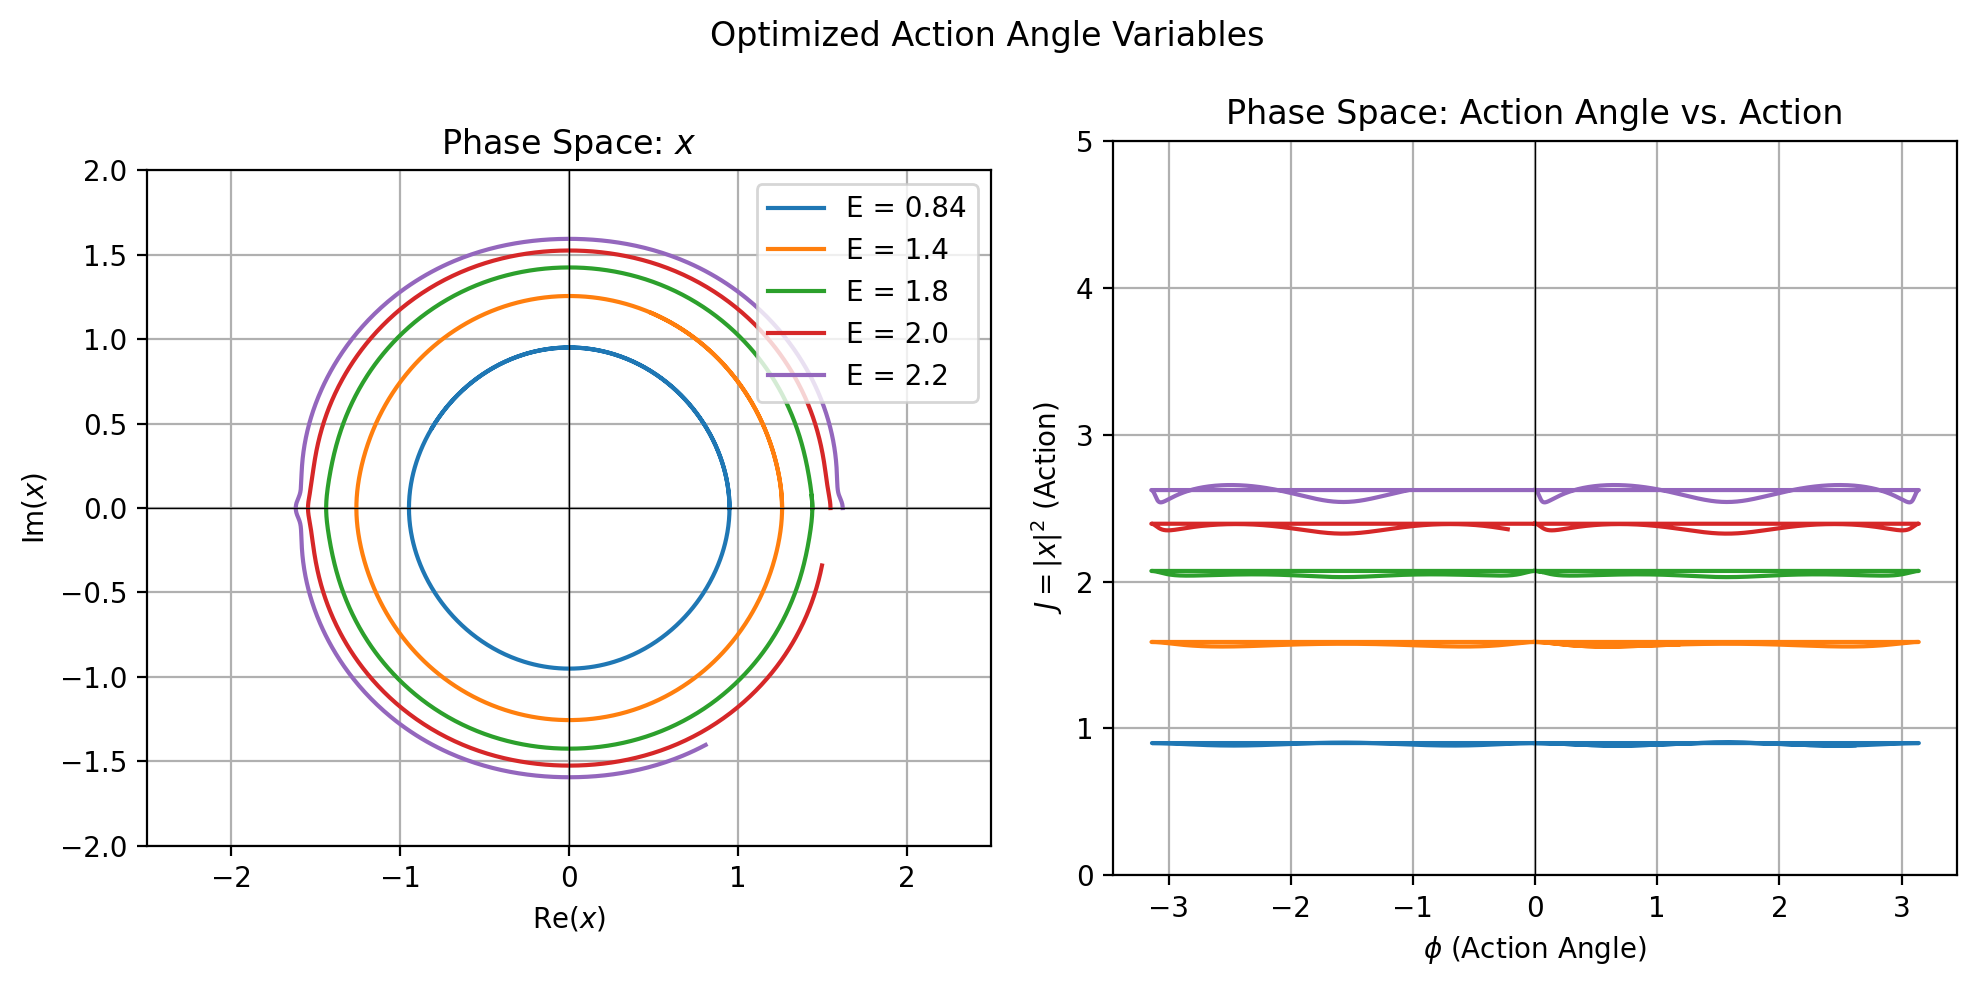

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(optim_h)):
    H = optim_h[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    z0 = [x0.real, x0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = x_sol.real + 1j * x_sol.imag

    xp_sol = xp_f_param(x_sol, x_bar_sol, omega_0_val, *optimal_coeffs.x)

    # Compute action variable J and action angle phi
    J_sol = np.abs(xp_sol) ** 2
    phi_sol = np.angle(xp_sol)

    # Plot phase space for x
    axes[0].plot(xp_sol.real, xp_sol.imag, label=f"E = {h_f(x_sol[0], x_bar_sol[0], omega_0_val).real:.2}")

    # Plot action angle space
    axes[1].plot(phi_sol, J_sol)
    
axes[0].legend(loc="upper right")
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $x$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()
axes[0].set_aspect('equal')
axes[0].set_xlim(-2.5,2.5)
axes[0].set_ylim(-2,2)

axes[1].set_xlabel(r'$\phi$ (Action Angle)')
axes[1].set_ylabel(r'$J = |x|^2$ (Action)')
axes[1].set_title('Phase Space: Action Angle vs. Action')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()
axes[1].set_ylim(0, 5)

plt.suptitle("Optimized Action Angle Variables")

plt.tight_layout()
plt.show()

The next plot shows the error in our transformation. Both lines should be straight and horizontal

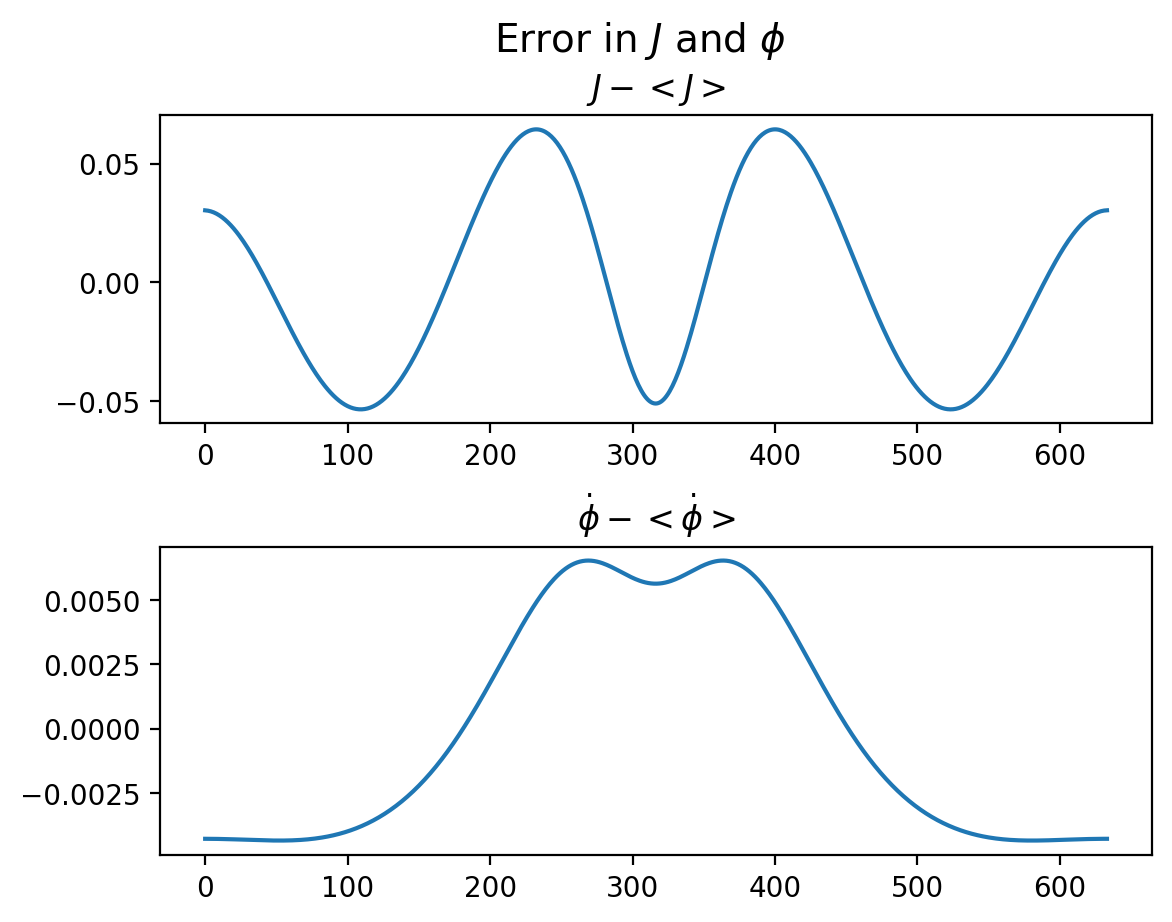

In [61]:
# Compute action variable J and action angle phi
J_sol = np.abs(xp_sol) ** 2
phi_sol = np.angle(xp_sol)

phi_sol_dot = np.gradient(phi_sol[(phi_sol > 0) & (phi_sol < np.pi)]) # get rid of angles outside of (0, pi) so we don't have to deal with discontinuities
J_sol_cropped = J_sol[(phi_sol > 0) & (phi_sol < np.pi)]

plt.subplot(2,1,1)
plt.title("$J - <J>$")
plt.plot(J_sol_cropped - np.mean(J_sol_cropped))
plt.subplot(2,1,2)
plt.title("$\dot \phi - <\dot \phi>$")
plt.plot(phi_sol_dot - np.mean(phi_sol_dot))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Error in $J$ and $\phi$", fontsize=14)
plt.show()